/Users/ulrikes/Desktop/HDR/raw/002/_07A5804.CR2 -> exposure time: 0.000125
/Users/ulrikes/Desktop/HDR/raw/002/_07A5805.CR2 -> exposure time: 0.001
/Users/ulrikes/Desktop/HDR/raw/002/_07A5806.CR2 -> exposure time: 0.008
/Users/ulrikes/Desktop/HDR/raw/002/_07A5807.CR2 -> exposure time: 0.06666666666666667
/Users/ulrikes/Desktop/HDR/raw/002/_07A5808.CR2 -> exposure time: 0.5


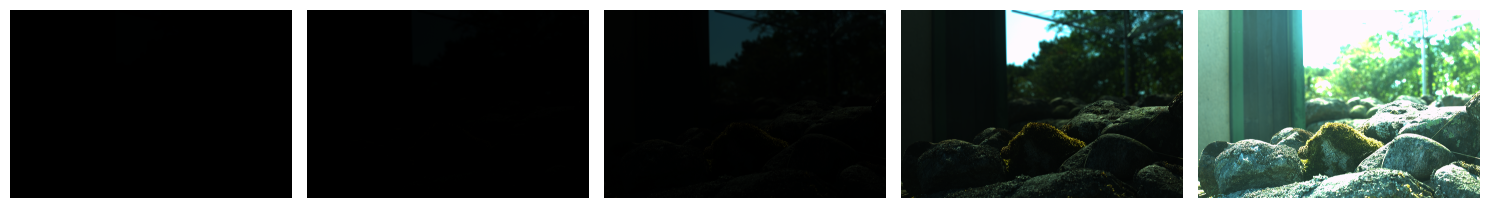

In [4]:
import rawpy
import imageio
from matplotlib import pyplot as plt
import glob
import numpy as np
import exifread
from fractions import Fraction

def get_exposure_time(path):  # i have to read out exposure times directly from the exif tags, i can't find it in the metadata
    with open(path, 'rb') as f:
        tags = exifread.process_file(f, stop_tag='EXIF ExposureTime')
    exp = tags.get('EXIF ExposureTime', None)
    if exp is None:
        return None
    return float(Fraction(str(exp)))

path = '/Users/ulrikes/Desktop/HDR/raw/002/'
img_files = sorted(glob.glob(path + '*.CR2'))


img_list=[]
exposure_times = []
for i in img_files[:]:

    with rawpy.imread(i) as raw:
        # Extract exposure time using exifread
        et = get_exposure_time(i)
        if et is None:
            et = 1.0  # fallback
        exposure_times.append(et)
        print(f"{i} -> exposure time: {et}")

        rgb = raw.postprocess(
            gamma=(1, 1),           #No gamma correction (linear)
            no_auto_bright=True,     # Don't automatically brighten
            use_camera_wb=True,      # use white balance from camera
            output_bps=16,          #Higher bit depth (16 bits per channel)
            user_wb=[1, 1, 1, 1],    # Neutral white balance (optional)
            bright=1.0               # Disable auto brightening
            )
        img_list.append(rgb)

plt.figure(figsize=(15, 5))
for idx, img in enumerate(img_list[:5]):  
    rgb_display = img.astype(np.float32) / 2**16  # convert to float for imshow
    plt.subplot(1, 5, idx + 1)
    plt.imshow(rgb_display)
    plt.axis('off')
plt.tight_layout()


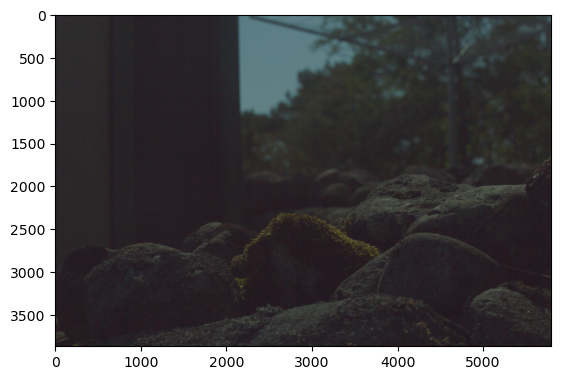

In [6]:
#  nice. lets start with the simplest hdr algorithm: a weighted average funcction, where the radiance is a weighted average of the exposures
# Lets try this weighing function

def weight(pixel_value):
    return np.minimum(pixel_value, 1 - pixel_value) # This favors mid-range pixels and downweights shadows and highlights.
    
def simple_hdr(images, exposure_times):
    images = np.array(images, dtype=np.float32)  # shape: (N, H, W, C)
    exposure_times = np.array(exposure_times, dtype=np.float32)
    
    weights = np.minimum(images, 1 - images)  
    weights = np.clip(weights, 1e-6, None)

    numerator = np.sum(weights * (images / exposure_times[:, None, None, None]), axis=0)
    denominator = np.sum(weights, axis=0)

    hdr = numerator / denominator
    return hdr  

hdr = simple_hdr(img_list, exposure_times)

plt.figure()
hdr_display = hdr.astype(np.float32)# / np.max(hdr)  # convert to float for imshow
hdr_display /= np.max(hdr_display)

gamma = 1/2.2
hdr_display_gamma = np.power(np.clip(hdr_display, 0, 1), gamma)
plt.imshow(hdr_display_gamma)
           

# this doesn't look good yet, needs more work.
